In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

## Preprocessing

In [2]:
pd.set_option('display.max_columns', None)

# COVID-19 testing data
testing = pd.read_csv('https://covidtracking.com/data/download/california-history.csv')
testing.head()

,date,state,dataQualityGrade,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,inIcuCumulative,inIcuCurrently,negative,negativeIncrease,negativeTestsAntibody,negativeTestsPeopleAntibody,negativeTestsViral,onVentilatorCumulative,onVentilatorCurrently,positive,positiveCasesViral,positiveIncrease,positiveScore,positiveTestsAntibody,positiveTestsAntigen,positiveTestsPeopleAntibody,positiveTestsPeopleAntigen,positiveTestsViral,recovered,totalTestEncountersViral,totalTestEncountersViralIncrease,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-01-26,CA,B,37527.0,NaN,409,NaN,NaN,NaN,18039.0,0,NaN,4384.0,37857584,304834,NaN,NaN,NaN,NaN,NaN,3153186,3153186.0,17028,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,41010770,321862,NaN,NaN,NaN,NaN,NaN,0,41010770,321862
1,2021-01-25,CA,B,37118.0,NaN,328,NaN,NaN,NaN,18347.0,0,NaN,4475.0,37552750,376186,NaN,NaN,NaN,NaN,NaN,3136158,3136158.0,27007,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,40688908,403193,NaN,NaN,NaN,NaN,NaN,0,40688908,403193
2,2021-01-24,CA,B,36790.0,NaN,429,NaN,NaN,NaN,18638.0,0,NaN,4542.0,37176564,291485,NaN,NaN,NaN,NaN,NaN,3109151,3109151.0,24111,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,40285715,315596,NaN,NaN,NaN,NaN,NaN,0,40285715,315596
3,2021-01-23,CA,B,36361.0,NaN,593,NaN,NaN,NaN,19293.0,0,NaN,4641.0,36885079,221308,NaN,NaN,NaN,NaN,NaN,3085040,3085040.0,22972,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39970119,244280,NaN,NaN,NaN,NaN,NaN,0,39970119,244280
4,2021-01-22,CA,B,35768.0,NaN,764,NaN,NaN,NaN,19855.0,0,NaN,4718.0,36663771,190059,NaN,NaN,NaN,NaN,NaN,3062068,3062068.0,23024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39725839,213083,NaN,NaN,NaN,NaN,NaN,0,39725839,213083


In [3]:
# Hospital data by county if needed
hospital_url = 'https://data.ca.gov/dataset/529ac907-6ba1-4cb7-9aae-8966fc96aeef/resource/42d33765-20fd-44b8-a978-b083b7542225/download/hospitals_by_county.csv'
hospital_df = pd.read_csv(hospital_url)

In [4]:
# recovery data?
testing['recovered'].unique()

array([nan])

In [5]:
testing = testing[['date', 'totalTestResults', 'totalTestResultsIncrease']]
testing.rename(columns={'totalTestResults': 'total_tests', 'totalTestResultsIncrease': 'new_tests'}, inplace=True)
testing = testing.sort_values(by='date', ascending=True).reset_index(drop=True)
testing.head()

,date,total_tests,new_tests
0,2020-03-04,515,0
1,2020-03-05,515,0
2,2020-03-06,522,7
3,2020-03-07,531,9
4,2020-03-08,550,19


In [6]:
# NY Times time series
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
nytimes = pd.read_csv(url)
nytimes = nytimes.loc[(nytimes['date'] >= '2020-03-04') &
                      (nytimes['state'] == 'California')].reset_index(drop=True)
nytimes.head()

,date,state,fips,cases,deaths
0,2020-03-04,California,6,55,1
1,2020-03-05,California,6,67,1
2,2020-03-06,California,6,81,1
3,2020-03-07,California,6,100,1
4,2020-03-08,California,6,112,1


In [7]:
# merge testing data and NY Times data
df = pd.merge(testing, nytimes, how='inner', on='date')
df.drop(['state', 'fips'], axis=1, inplace=True)
df.rename(columns={'cases': 'total_cases', 'deaths': 'total_deaths'}, inplace=True)
df.head()

,date,total_tests,new_tests,total_cases,total_deaths
0,2020-03-04,515,0,55,1
1,2020-03-05,515,0,67,1
2,2020-03-06,522,7,81,1
3,2020-03-07,531,9,100,1
4,2020-03-08,550,19,112,1


In [8]:
# create daily cases and daily deaths columns
df['new_cases'] = df['total_cases'].diff()
df['new_deaths'] = df['total_deaths'].diff()
df.fillna(0, inplace=True)
df['new_cases'] = df['new_cases'].astype('int')
df['new_deaths'] = df['new_deaths'].astype('int')
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-04,515,0,55,1,0,0
1,2020-03-05,515,0,67,1,12,0
2,2020-03-06,522,7,81,1,14,0
3,2020-03-07,531,9,100,1,19,0
4,2020-03-08,550,19,112,1,12,0


In [9]:
# add positivity rate column
df['positivity_rate'] = df['total_cases']/df['total_tests']
df.head()

,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


In [10]:
df.to_csv('california_covid19.csv')
print(df.shape)
df.head()

(329, 8)


,date,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
0,2020-03-04,515,0,55,1,0,0,0.106796
1,2020-03-05,515,0,67,1,12,0,0.130097
2,2020-03-06,522,7,81,1,14,0,0.155172
3,2020-03-07,531,9,100,1,19,0,0.188324
4,2020-03-08,550,19,112,1,12,0,0.203636


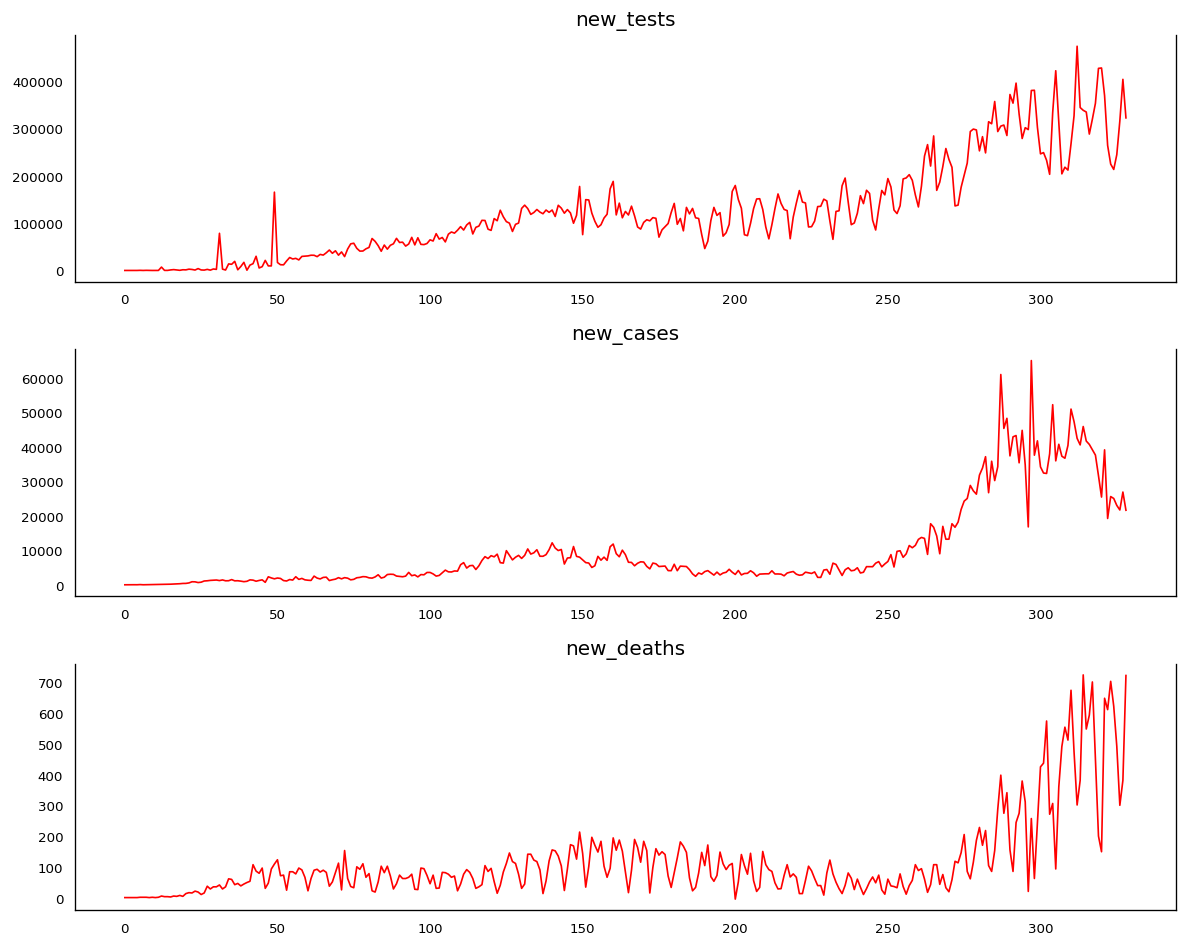

In [11]:
plot_df = df.loc[:, ['new_tests', 'new_cases', 'new_deaths']]
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,8))
plt.rc('font', size=10)
for i, ax in enumerate(axes.flatten()): 
    data = plot_df[plot_df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(plot_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.tight_layout()

## Correlation

In [12]:
# Our null hypothesis is that the correlation coefficient is not significantly different from 0.
def pearson_corr(column1, column2):
    corr_coef, p_value = pearsonr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)

def spearman_corr(column1, column2):
    corr_coef, p_value = spearmanr(column1, column2)
    print('correlation:', corr_coef)
    print('p value:', p_value)
    
pearson_corr(df['new_cases'], df['new_deaths'])

correlation: 0.731287361652476
p value: 2.7609964950603994e-56


P-value is less than 0.05, so we can conclude there is a positive correlation between new deaths and new cases.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


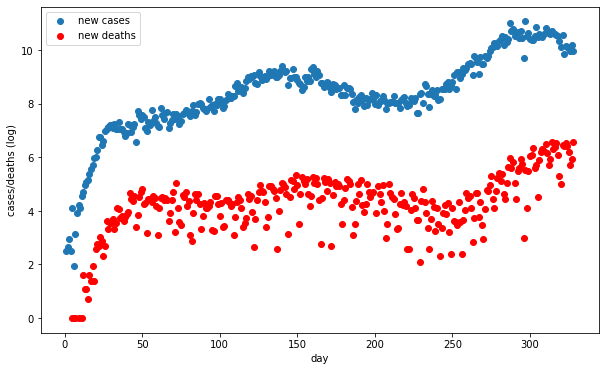

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, len(df)), np.log(df['new_cases']), label='new cases')
plt.scatter(np.arange(0, len(df)), np.log(df['new_deaths']), label='new deaths', c='red')
plt.legend()
plt.xlabel('day')
plt.ylabel('cases/deaths (log)')
plt.show()

In [14]:
pearson_corr(df['positivity_rate'], df['total_deaths'])

correlation: -0.40086590344044376
p value: 3.941952105944471e-14


In [15]:
df.corr(method='spearman')

,total_tests,new_tests,total_cases,total_deaths,new_cases,new_deaths,positivity_rate
total_tests,1.000000,0.919509,1.000000,0.999998,0.836306,0.514380,-0.456779
new_tests,0.919509,1.000000,0.919508,0.919501,0.871636,0.477939,-0.395366
total_cases,1.000000,0.919508,1.000000,0.999998,0.836306,0.514381,-0.456775
total_deaths,0.999998,0.919501,0.999998,1.000000,0.836316,0.514462,-0.456799
new_cases,0.836306,0.871636,0.836306,0.836316,1.000000,0.636385,-0.316282
new_deaths,0.514380,0.477939,0.514381,0.514462,0.636385,1.000000,0.057285
positivity_rate,-0.456779,-0.395366,-0.456775,-0.456799,-0.316282,0.057285,1.000000


## VAR

In [16]:
deaths_df = df[['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']]
deaths_df.shape

(329, 5)

In [17]:
train, test = np.split(deaths_df, [int(.7 *len(deaths_df))])
print(train.shape, test.shape)

(230, 5) (99, 5)


In [18]:
def plot(title):
    plt.figure(figsize=(10,6))
    plt.rc('font', size=12)
    plt.plot(np.arange(0, len(deaths_df)), deaths_df['total_deaths'], label='actual deaths')
    plt.plot(np.arange(0, len(pred_df)), pred_df['total_deaths'], '--', label='forecasted deaths', c='red')
    plt.xlabel('day')
    plt.ylabel('deaths')
    plt.legend()
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(title)
    plt.show()

In [19]:
# num_intervals = list(range(10, 30))
# for i in num_intervals:  
#     split_df = np.array_split(deaths_df, i) # splits data into certain number of intervals
#     cols = ['new_tests', 'total_deaths', 'new_cases', 'new_deaths', 'positivity_rate']
#     pred_df = pd.DataFrame(columns=cols) # create empty df for predictions
    
#     # predict for each df in the split df and append predictions to empty df
#     for df in split_df:
#         deaths_model = VAR(df)
#         model_fit = deaths_model.fit()
#         prediction = pd.DataFrame(model_fit.forecast(model_fit.y, steps=len(split_df[0])), columns=cols)
#         pred_df = pred_df.append(prediction, ignore_index=True)
#     pred_df['new_tests'] = pred_df['new_tests'].astype('int64')
#     pred_df['total_deaths'] = pred_df['total_deaths'].astype('int64')
#     pred_df['new_cases'] = pred_df['new_cases'].astype('int64')
#     pred_df['new_deaths'] = pred_df['new_deaths'].astype('int64')
#     plot('actual vs forecasted deaths using {} intervals'.format(i))

## ARIMA

### Forecast 1 day at a time

In [20]:
x = deaths_df['total_deaths']
size = int(len(x) * 0.7)
train, test = x[0:size], x[size:len(x)]
print(train.shape, test.shape)

(230,) (99,)


https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

order = (3,1,0) sets the lag value to 3 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0

In [21]:
history = [i for i in train]
pred = []
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast() # perform 1 step forecast
    yhat = output[0]
    pred.append(yhat)
    obs = np.array(test)[t]
    history.append(obs)

In [22]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  328
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1867.861
Date:                Wed, 27 Jan 2021   AIC                           3743.721
Time:                        11:49:19   BIC                           3758.881
Sample:                             0   HQIC                          3749.770
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8042      0.034     23.359      0.000       0.737       0.872
ar.L2         -0.0090      0.037     -0.245      0.806      -0.081       0.063
ar.L3          0.1378      0.026      5.229      0.000       0.086       0.189
sigma2      5328.1265    204.456     26.060      0.000    4927.400    5728.853
===================================================================================
Ljung-Box (Q):                      531.25   Jarque-Bera (JB):               894.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.65   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
def metrics(test, pred):  
    mae = mean_absolute_error(test, pred)
    rmse = math.sqrt(mean_squared_error(test, pred))
    r2 = r2_score(test, pred)
    print('mae:', mae)
    print('rmse:', rmse)
    print('r2:', r2)

metrics(test, pred)

mae: 88.83948672535332
rmse: 128.03954989753038
r2: 0.9995470638177281


In [24]:
data = {'actual': test, 'prediction': pred, 'diff': test-pred}
pred_df = pd.DataFrame(data)
pred_df['upper'] = pred_df['prediction'] + 1.96*pred_df['diff']
pred_df['lower'] = pred_df['prediction'] - 1.96*pred_df['diff']
pred_df

,actual,prediction,diff,upper,lower
230,17067,16996.835516,70.164484,17134.357905,16859.313127
231,17189,17143.412687,45.587313,17232.763821,17054.061553
232,17266,17276.540358,-10.540358,17255.881256,17297.199461
233,17316,17327.898607,-11.898607,17304.577337,17351.219877
234,17345,17377.583827,-32.583827,17313.719526,17441.448129
...,...,...,...,...,...
324,36326,36365.125897,-39.125897,36288.439139,36441.812655
325,36818,36915.276966,-97.276966,36724.614113,37105.939819
326,37118,37312.683814,-194.683814,36931.103539,37694.264089
327,37499,37437.006079,61.993921,37558.514165,37315.497993


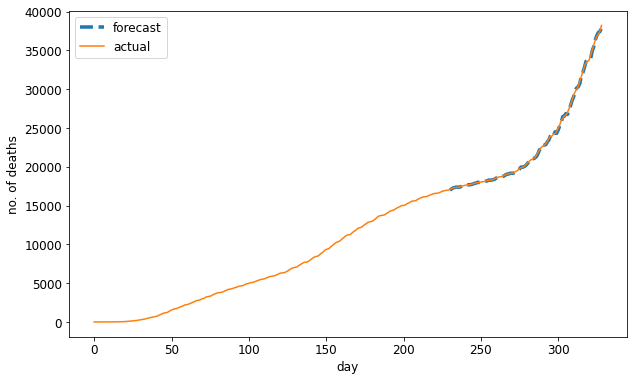

In [25]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(train), len(train)+len(pred)), pred, '--', label='forecast', linewidth=3.5)
plt.plot(np.arange(0, len(x)), x, label='actual')
plt.xlabel('day')
plt.ylabel('no. of deaths')
plt.legend()
plt.show()

### Forecast a certain number of days at once

In [26]:
x = deaths_df['total_deaths']

def split_data(split_size):
    size = int(len(x) * split_size)
    train, test = x[0:size], x[size:len(x)]
    print(train.shape, test.shape)
    return train, test

def arima(train, test):
    model = ARIMA(train, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast(steps=len(test))
    return output

def plot_pred(train, output, title):
    plt.figure(figsize=(8,5))
    plt.rcParams.update({'font.size': 12})
    plt.plot(np.arange(len(train), len(train)+len(output)), output, '--', label='forecast', linewidth=3)
    plt.plot(np.arange(0, len(x)), x, label='actual')
    plt.xlabel('day')
    plt.ylabel('no. of deaths')
    plt.title(title)
    plt.legend()
    plt.show()

In [27]:
train1, test1 = split_data(0.6)
train2, test2 = split_data(0.7)
train3, test3 = split_data(0.8)
train4, test4 = split_data(0.9)
train5, test5 = split_data(0.95)


arima1 = arima(train1, test1)
arima2 = arima(train2, test2)
arima3 = arima(train3, test3)
arima4 = arima(train4, test4)
arima5 = arima(train5, test5)

(197,) (132,)
(230,) (99,)
(263,) (66,)
(296,) (33,)
(312,) (17,)


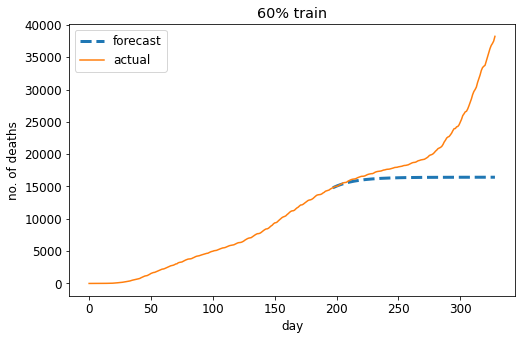

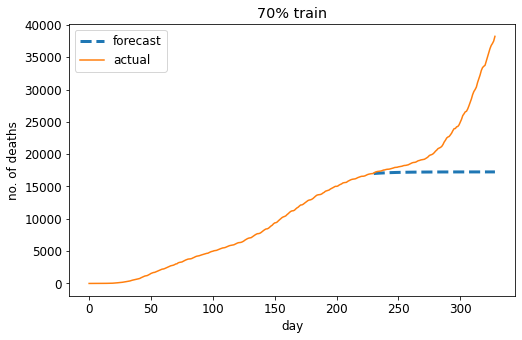

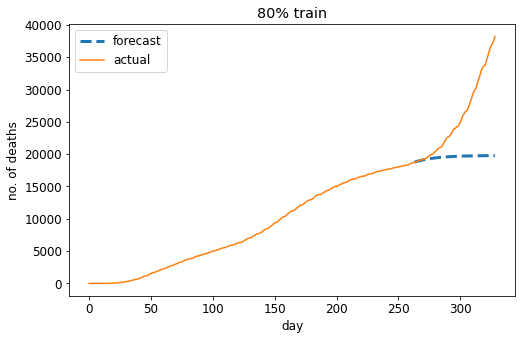

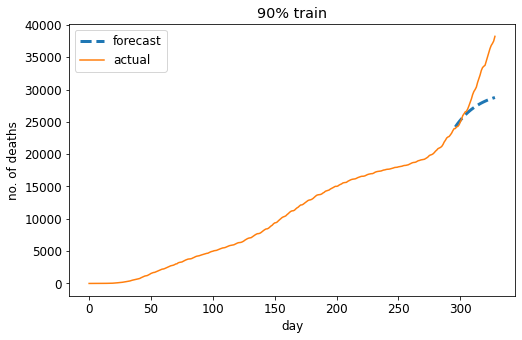

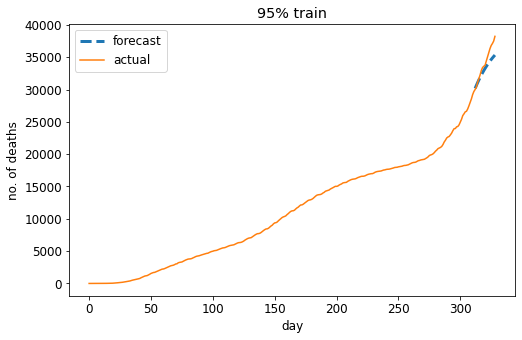

In [28]:
plot_pred(train1, arima1, '60% train')
plot_pred(train2, arima2, '70% train')
plot_pred(train3, arima3, '80% train')
plot_pred(train4, arima4, '90% train')
plot_pred(train5, arima5, '95% train')

In [29]:
metrics(test5, arima5)

mae: 1109.9017433940544
rmse: 1416.991412083542
r2: 0.6739695861392591


### Forecast the future

In [30]:
# fit model with whole dataset
model = ARIMA(deaths_df['total_deaths'], order=(3,1,0))
fit = model.fit()
pred = fit.forecast(steps=60)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_deaths   No. Observations:                  329
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1883.824
Date:                Wed, 27 Jan 2021   AIC                           3775.647
Time:                        11:49:21   BIC                           3790.819
Sample:                             0   HQIC                          3781.700
                                - 329                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8202      0.036     22.836      0.000       0.750       0.891
ar.L2         -0.0515      0.038     -1.370      0.171      -0.125       0.022
ar.L3          0.1790      0.026      6.758      0.000       0.127       0.231
sigma2      5668.1398    220.556     25.699      0.000    5235.858    6100.421
===================================================================================
Ljung-Box (Q):                      562.50   Jarque-Bera (JB):               788.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.83   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

residuals = actual - prediction

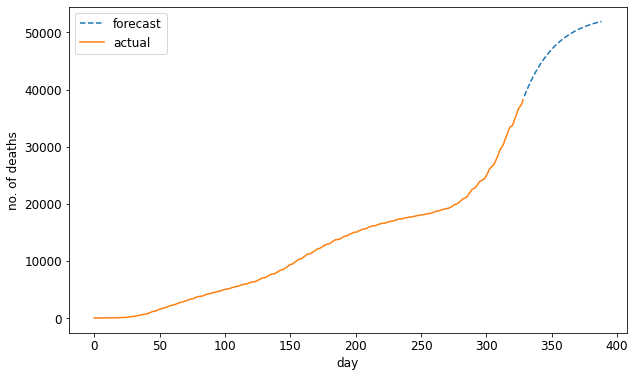

In [31]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
plt.plot(np.arange(len(deaths_df), len(deaths_df)+len(pred)), pred, '--', label='forecast')
plt.plot(np.arange(0, len(deaths_df)), x, label='actual')
plt.xlabel('day')
plt.ylabel('no. of deaths')
plt.legend()
plt.show()

Next steps: 
- modify the model so it can take into account how many people have been vaccinated

## County Data

In [32]:
# url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
# url = 'https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv'
# df = pd.read_csv(url)
# df.rename(columns={'totalcountconfirmed': 'total_cases', 'totalcountdeaths': 'total_deaths', 
#                    'newcountconfirmed': 'new_cases', 'newcountdeaths': 'new_deaths'}, inplace=True)
# df.head()

In [33]:
# def create_county_data(county_name):
#     county = df.loc[df['county'] == county_name].reset_index(drop=True)
#     county['day'] = np.arange(0, len(county['date']))
#     return county

# sample = create_county_data('Los Angeles')
# sample